## 4.6 Dropout

we have a prior belief that weights take values from a Gaussian distribution with mean zero.

Naively applied, linear models do not take into account interactions among features.

tension between generalizability and flexibility is described as the *bias-variance tradeoff*. For example, linear models have high bias : they can only represent a small class of functions. However, these models have low variance : they give similar results across different random samples of the data.

Despite the absence of any true pattern linking the inputs to the outputs, they found that the neural network optimized by stochastic gradient desent could label every image in the training set perfectly.

The mathematical foundations for the puzzling generalization properties of deep networks remain open research questions, and we encourage the theoretically-oriented reader to dig deeper into the topic.

For now, we turn to the investigation of practical tools that tend to empirically improve the generalization of deep nets.

dropout : Throughout training, on each iteration, standard dropout consists of zeroing out some fraction of the nodes in each layer before calculating the subsequent layer.

In standard dropout regularization, one debiases each layer by normalizing by the fraction of nodes that were retained (not dropped out). In other words, with *dropout probability p*, each itermediate activation *h* is replaced by a random variable h' as follows:

$$ h' = 0 with probability  p, \frac{h}{1-p} o.w. $$ 

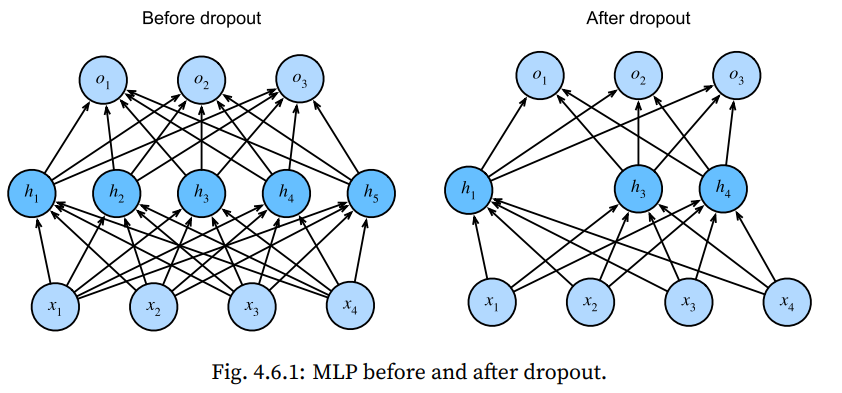

we ensure that dropout is only active during training.

In [ ]:
!pip install d2l==0.14.2

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l
from torch import nn

In [ ]:
def dropout_layer(X, dropout):
  assert 0 <= dropout <= 1
  # In this case, all elements are dropped out
  if dropout == 1:
    return torch.zeros_like(X)
  # In this case, all elements are kept
  if dropout == 0:
    return X
  mask = (torch.rand(X.shape) > dropout).float()
  return mask * X / (1.0 - dropout)

In [ ]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  0.,  0.,  0., 12.,  0.],
        [ 0.,  0., 20., 22., 24.,  0.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [ ]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [ ]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
  def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training = True):
    super(Net, self).__init__()
    self.num_inputs = num_inputs
    self.training = is_training
    self.lin1 = nn.Linear(num_inputs, num_hiddens1)
    self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
    self.lin3 = nn.Linear(num_hiddens2, num_outputs)
    self.relu = nn.ReLU()

  def forward(self, X):
    H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
    # Use dropout only when training the model
    if self.training == True:
      # Add a dropout layer after the first fully connected layer
      H1 = dropout_layer(H1, dropout1)
    H2 = self.relu(self.lin2(H1))
    if self.training == True:
      # Add a dropout layer after the second fully connected layer
      H2 = dropout_layer(H2, dropout2)
    out = self.lin3(H2)
    return out


In [ ]:
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

In [ ]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction = 'none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr = lr)

In [ ]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [ ]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    # Add a dropout layer after the first fully connected layer
                    nn.Dropout(dropout1),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    # Add a dropout layer after the second fully connected layer
                    nn.Dropout(dropout2),
                    nn.Linear(256, 10)

)

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std = 0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# train and test the model
trainer = torch.optim.SGD(net.parameters(), lr = lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## Summary
* Beyond controlling the number of dimensions and the size of the weight vector, dropout is yer another tool to avoid overfitting. Often they are used jointly.

* Dropout replaces an activation *h* with a random variable with expected value *h*.

* Dropout is only used during training.

## 4.7 Forward Propagation, Backward Propagation, and Computational Graphs

## Summary
* Forward propagation sequentially calculates and stores intermediate variables within the computational graph defined by the neural network. It proceeds from the input to the output layer.

* Backpropagation sequentially calculates and stores the gradients of intermediate variables and parameters within the neural network in the reversed order.

* When training deep learning models, forward propagation and back propagation are interdependent.

* Training requires significantly more memory than prediction.

## 4.8 Numerical Stability and Initialization

the choice of initialization scheme plays a significant role in neural network learning, and it can be crucial for maintaining numerical stability.

We may be facing parameter updates that are either 1) excessively large, destroying our model(the *exploding gradient* problem) 2) excessively small (the *vanishing gradient* problem), rendering learning impossible as parameters hardly move on each update.

sigmoid function is famous as vanishing gradients. As you can see below, the sigmoid's gradient vanishes both when its inputs are large and when they are small.

Consequently, ReLUs, which are more stable ( but less neurally plausible), have emerged as the default choice for practitioners.

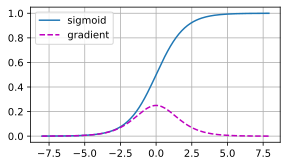

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad = True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()], legend = ['sigmoid', 'gradient'], figsize = (4.5, 2.5))

For the scale that we picked, the matrix product explodes. When this happens due to the initialization of a deep network, we have no chance of getting a gradient descent optimizer to converge.

In [ ]:
M = torch.normal(0, 1, size = (4, 4))
print('a single matrix \n', M)
for i in range(100):
  M = torch.mm(M,torch.normal(0, 1, size = (4, 4)))

print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[-1.3254,  1.2379,  0.5592,  0.4929],
        [ 0.6887,  1.6211,  1.2902,  0.3477],
        [-0.0527,  0.8536,  0.5445,  1.2910],
        [-1.1836, -0.2320, -1.3579,  1.2624]])
after multiplying 100 matrices
 tensor([[ 7.1827e+22,  1.9261e+23,  3.3368e+20, -2.4567e+23],
        [ 5.4371e+22,  1.4580e+23,  2.5260e+20, -1.8596e+23],
        [ 1.4829e+23,  3.9766e+23,  6.8891e+20, -5.0720e+23],
        [ 1.0690e+23,  2.8666e+23,  4.9662e+20, -3.6563e+23]])


#### breaking the symmetry
Another problem in neural network design is the symmetry inherent in their parametrization. There is nothing special differentiating the first hidden unit vs. the second hidden unit. In other words, we have permutation symmetry among the hidden units of each layer.

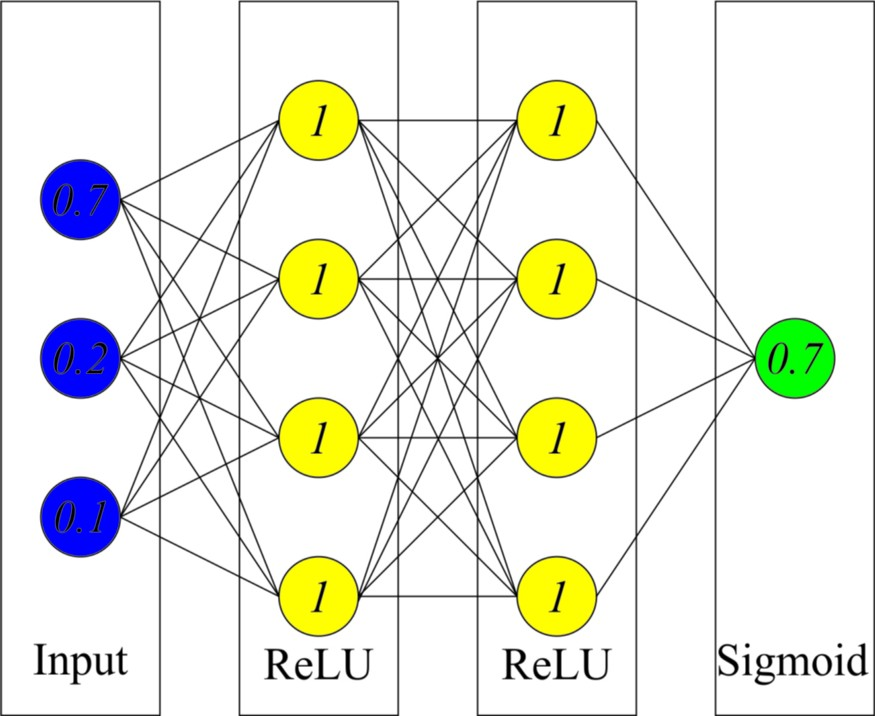


Notice that every neuron in the same layer has the same behavior, and will be ended up having the same weight. This phenomenon is called the **symmetric problem**.

The solution to address this problem is quite simple, just **randomize the initial weight**.

Though the assumption for nonexistence of nonlinearities in the above mathematical reasoning can be easily violated in neural networks, the Xavier initialization method turns out to work well in practice.

## Summary
* Vanishing and exploding gradients are common issues in deep networks. Great care in parameter initialization is required to ensure that gradients and parameters remain well controlled.

* Initialization heuristics are needed to ensure that the initial gradients are neither too large nor too small.

* ReLU activation functions mitigate the vanishing gradient problem. This can accelerate convergence.

* Random initialization is key to ensure that symmetry is broken before optimization.

* Xavier initialization suggests that, for each layer, variance of any output is not affected by the number of inputs, and variance of any gradient is not affected by the number of outputs.

## 4.9 Environment and Distribution Shift

Sometimes models appear to perform marvelously as measured by test set accuraccy but fail catastrophically in deployment when the distribution of data suddenly shifts.

Among categories of distribution shift, covariate shift may be the most widely studied. Statisticians call this *covariate shift* because the problem arises due to a shift in the distribution of the covariates(features).

model -> data -> estimate -> observation -> loss -> model

## Summary

* In many cases training and test sets do not come from the same distribution. This is called distribution shift.

* The risk is the expectation of the loss over the entire population of data drawn from their true distribution. However, this entire population is usually unavailable. Empirical risk is an average loss over the training data to approxiate the risk. In practice, we perform empirical risk minimization.

* Under the corresponding assumptions, covariate and label shift can be detected and corrected for at test time. Failure to accout for this bais can become problematic at test time.

* In some cases, the environment may remember automated actions and respond in surprising ways. We must account for this possibility when building models and continue to monitor live systems, open to the possibility that our models and the environment will become entangled in unanticipated ways.

In [15]:
import hashlib
import os
import tarfile
import zipfile
import requests

In [24]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [16]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [31]:
def download(name, cache_dir = os.path.join('..', 'data')):
  """Download a file inserted into DATA_HUB, return the local filename."""
  assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
  url, sha1_hash = DATA_HUB[name]
  os.makedirs(cache_dir, exist_ok = True)
  fname = os.path.join(cache_dir, url.split('/')[-1])
  if os.path.exists(fname):
    sha1 = hashlib.sha1()
    with open(fname, 'rb') as f:
      while True:
        data = f.read(1048576)
        if not data:
          break
        sha1.update(data)
    if sha1.hexdigest() == sha1_hash:
      return fname
  print(f'Downloading {fname} from {url}...')
  r = requests.get(url, stream = True, verify = True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname

In [32]:
import pandas as pd
import numpy as np

In [33]:
DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = ( 
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [34]:
train_data = pd.read_csv(download('kaggle_house_train'))

In [35]:
test_data = pd.read_csv(download('kaggle_house_test'))

In [36]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [38]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [39]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [42]:
# If test data were inaccessible, mean and standard deviation could calculated from training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
# After standardizing the data all means vanish, hence we can set missing values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [43]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na = True)
all_features.shape

(2919, 331)

In [44]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype = torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype = torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype = torch.float32
)

In [45]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
  net = nn.Sequential(nn.Linear(in_features, 1))
  return net

In [46]:
def log_rmse(net, features, labels):
  # To further stabilize the value when the logarithm is taken, set the value less than 1 as 1
  clipped_preds = torch.clamp(net(features), 1, float('inf'))
  rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
  return rmse.item()

In [47]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
  train_ls, test_ls = [], []
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  # The Adam optimization algorithm is used here
  optimizer = torch.optim.Adam(net.parameters(),
                               lr = learning_rate,
                               weight_decay = weight_decay)
  for epoch in range(num_epochs):
    for X, y in train_iter:
      optimizer.zero_grad()
      l = loss(net(X), y)
      l.backward()
      optimizer.step()
    train_ls.append(log_rmse(net, train_features, train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net, test_features, test_labels))
  return train_ls, test_ls

In [48]:
# model seleciton
def get_k_fold_data(k, i, X, y):
  assert k > 1
  fold_size = X.shape[0] // k
  X_train, y_train = None, None
  for j in range(k):
    idx = slice(j * fold_size, (j+1) * fold_size)
    X_part, y_part = X[idx, :], y[idx]
    if j == i:
      X_valid, y_valid = X_part, y_part
    elif X_train is None:
      X_train, y_train = X_part, y_part
    else:
      X_train = torch.cat([X_train, X_part], 0)
      y_train = torch.cat([y_train, y_part], 0)
  return X_train, y_train, X_valid, y_valid

In [49]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
  train_l_sum, valid_l_sum = 0, 0
  for i in range(k):
    data = get_k_fold_data(k, i, X_train, y_train)
    net = get_net()
    train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
    train_l_sum += train_ls[-1]
    valid_l_sum += valid_ls[-1]
    if i == 0:
      d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel = 'epoch', ylabel='rmse', xlim = [1, num_epochs], legend = ['train', 'valid'], yscale = 'log')
    print(f'fold {i+1}, train log rmse {float(train_ls[-1]):f}, '
          f'valid log rmse {float(valid_ls[-1]):f}')
  return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.169768, valid log rmse 0.156564
fold 2, train log rmse 0.162206, valid log rmse 0.189848
fold 3, train log rmse 0.163918, valid log rmse 0.168155
fold 4, train log rmse 0.167731, valid log rmse 0.154492
fold 5, train log rmse 0.163142, valid log rmse 0.182909
5-fold validation: avg train log rmse: 0.165353, avg valid log rmse: 0.170394


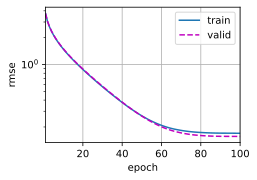

In [50]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

In [51]:
# submitting predictions on Kaggle
def train_and_pred(train_features, test_feature, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
  net = get_net()
  train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
  d2l.plot(np.arange(1, num_epochs+1), [train_ls], xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
  print(f'train log rmse {float(train_ls[-1]):f}')
  # Apply the network to the test set
  preds = net(test_features).detach().numpy()
  # Reformat it to export to Kaggle
  test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
  submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis = 1)
  submission.to_csv('submission.csv', index = False)

train log rmse 0.162378


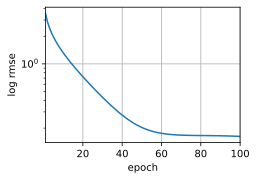

In [52]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

## Summary

* Real data often contain a mix of different data types and need to be preprocessed.

* Rescaling real-valued datea to zero mean and unit variance is a good default. So is replacing missing vlaues with their mean.

* Transforming categorical features into indicator features allows us to treat them like one-hot-vectors.

* We can use *K*-fold cross-validation to select the model and adjust the hyperparameters.

* Logarithms are useful for relative errors.

In [37]:
# def download_extract(name, folder = None):
#   """Download and extract a zip/tar file."""
#   fname = download(name)
#   base_dir = os.path.dirname(fname)
#   data_dir, ext = os.path.splitext(fname)
#   if ext == '.zip':
#     fp = zipfile.ZipFile(fname, 'r')
#   elif ext in ('.tar', '.gz'):
#     fp = tarfile.open(fname, 'r')
#   else:
#     assert False, 'Only zip/tar files can be extracted.'
#   fp.extractall(base_dir)
#   return os.path.join(base_dir, folder) if folder else data_dir

# def download_all():
#   """Download all files in the DATA_HUB."""
#   for name in DATA_HUB:
#     download(name)